# Clases y funciones

## Clases

## Funciones

### Función GridSearch con Balanceo

In [1]:
def grid_search_with_and_without_balance(model, param_grid, X_train, y_train, X_test, y_test, sampler=None, random_seed=None, balance_type=None):
    """
    Realiza una búsqueda en cuadrícula para optimizar los hiperparámetros de un modelo,
    con opciones para balancear las clases.

    Args:
        model: Modelo de aprendizaje automático.
        param_grid: Diccionario con los parámetros a probar.
        X_train: Características del conjunto de entrenamiento.
        y_train: Etiquetas del conjunto de entrenamiento.
        X_test: Características del conjunto de prueba.
        y_test: Etiquetas del conjunto de prueba.
        sampler: Método de balanceo de clases (1: 'balanced', 2: submuestreo, 3: sobremuestreo).
        random_seed: Semilla para la aleatoriedad (opcional).
        balance_type: Nombre del tipo de balanceo.

    Returns:
        accuracy, precision, recall, f1, roc_auc, best_params, model.
    """
    print(f"\n--> Iniciando {balance_type} para {model.__class__.__name__} con semilla {random_seed}")

    # Ajustar el modelo según el método de balanceo especificado
    if sampler == 1:
        model.set_params(class_weight='balanced')
    elif sampler == 2:
        sampler = RandomUnderSampler(random_state=random_seed)
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    elif sampler == 3:
        sampler = RandomOverSampler(random_state=random_seed)
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Realizar la búsqueda en cuadrícula
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Ajustar el modelo con los mejores parámetros
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calcular métricas de rendimiento
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de Confusión - {balance_type} {model.__class__.__name__} semilla {random_seed}')
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {balance_type} {model.__class__.__name__} semilla {random_seed}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"--> Final de {balance_type} para {model.__class__.__name__} con semilla {random_seed}")
    return accuracy, precision, recall, f1, roc_auc, best_params, model

### Función impresión de resultados

In [2]:
def print_results(results, model_name, balance_type, random_seed):
    if isinstance(results, tuple) and len(results) == 7:
        accuracy, precision, recall, f1, roc_auc, best_params, model = results
        print(f"  {model_name} - {balance_type} (Semilla {random_seed})")
        print(f"    Accuracy: {accuracy}")
        print(f"    Precision: {precision}")
        print(f"    Recall: {recall}")
        print(f"    F1 Score: {f1}")
        print(f"    ROC-AUC: {roc_auc}")
        print(f"    Best Parameters: {best_params}")

        # Guardar el modelo entrenado
        model_filename = f"model_{model_name}_{balance_type}_seed_{random_seed}.pkl"
        with open(model_filename, "wb") as file:
            pickle.dump(model, file)
        print(f"Modelo guardado como {model_filename}")
    else:
        print(f"Formato desconocido de resultados para {model_name} - {balance_type} (Semilla {random_seed})")

# Cargar librerias y dataset

## Cargar librerias

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import os

## Cargar dataset

In [4]:
url= "./../code/data_copy.csv"
data = pd.read_csv(url)
data_copy = data.copy()

# Modelo Machine Learning

## Defenir features y target

In [5]:
features = data_copy.drop(["is_fraud"], axis=1)
target = data_copy.is_fraud

## Separar características numéricas y categóricas

In [6]:
numeric_features = features.select_dtypes(include=['number']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

## Creación del preprocesador

In [7]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Inicializar el Diccionario para Almacenar Resultados

In [8]:
results_by_seed = {}
models_by_seed = {}  

best_global_f1 = -1
best_global_model = None
best_global_approach = None
best_global_seed = None
best_global_params = None
best_models_by_approach = {
    'weighted': {'model': None, 'params': None, 'f1': -1},
    'undersampling': {'model': None, 'params': None, 'f1': -1},
    'oversampling': {'model': None, 'params': None, 'f1': -1},
    'unbalanced': {'model': None, 'params': None, 'f1': -1}
}

## Lista de modelos y parámetros a probar


=== Evaluación con Semilla 42 ===
Modelo no encontrado: model_DecisionTreeClassifier_weighted_seed_42.pkl. Procediendo con el entrenamiento.
--> Iniciando weighted para DecisionTreeClassifier

--> Iniciando weighted para DecisionTreeClassifier con semilla 42


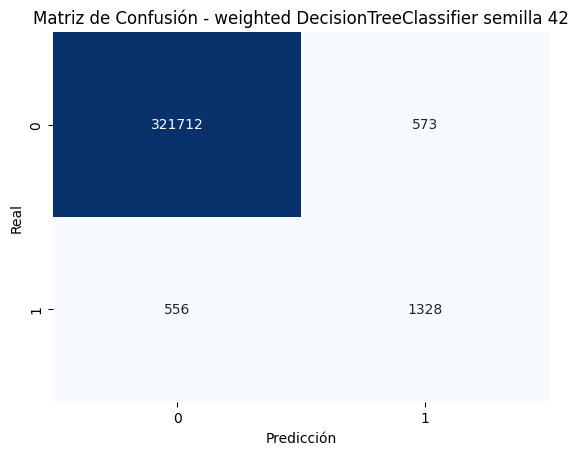

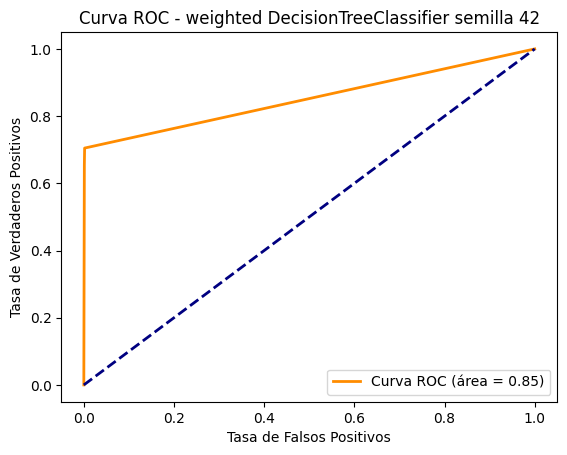

--> Final de weighted para DecisionTreeClassifier con semilla 42
  DecisionTreeClassifier - weighted (Semilla 42)
    Accuracy: 0.9965172487190324
    Precision: 0.6985796948974224
    Recall: 0.7048832271762208
    F1 Score: 0.7017173051519154
    ROC-AUC: 0.8517263776338062
    Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Modelo guardado como model_DecisionTreeClassifier_weighted_seed_42.pkl
--> Iniciando undersampling para DecisionTreeClassifier

--> Iniciando undersampling para DecisionTreeClassifier con semilla 42


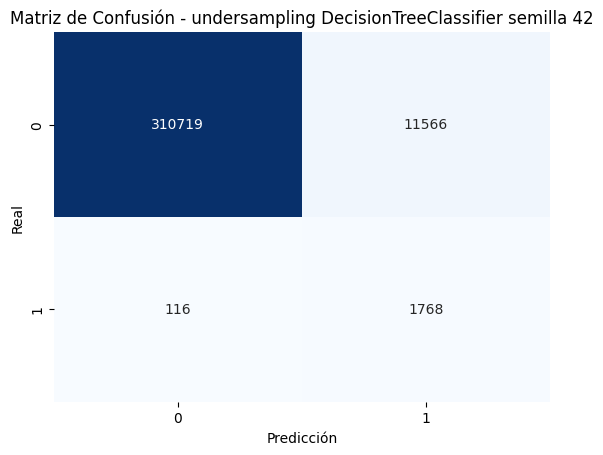

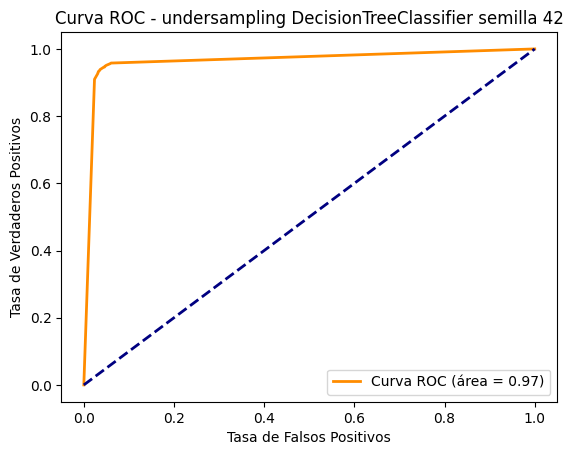

--> Final de undersampling para DecisionTreeClassifier con semilla 42
  DecisionTreeClassifier - undersampling (Semilla 42)
    Accuracy: 0.9639632413956918
    Precision: 0.1325933703314834
    Recall: 0.9384288747346072
    F1 Score: 0.23235642002891313
    ROC-AUC: 0.9651487815228093
    Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}
Modelo guardado como model_DecisionTreeClassifier_undersampling_seed_42.pkl
--> Iniciando oversampling para DecisionTreeClassifier

--> Iniciando oversampling para DecisionTreeClassifier con semilla 42


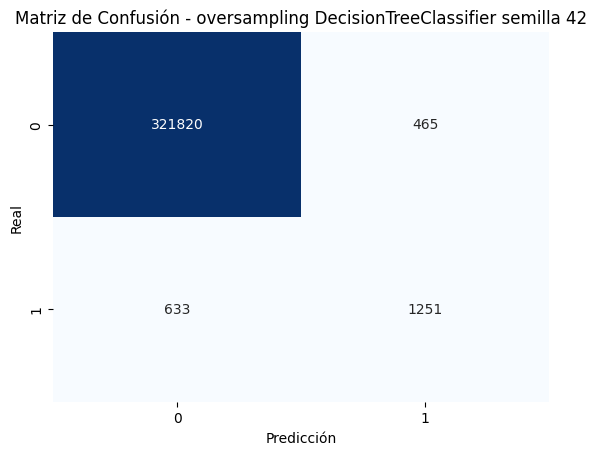

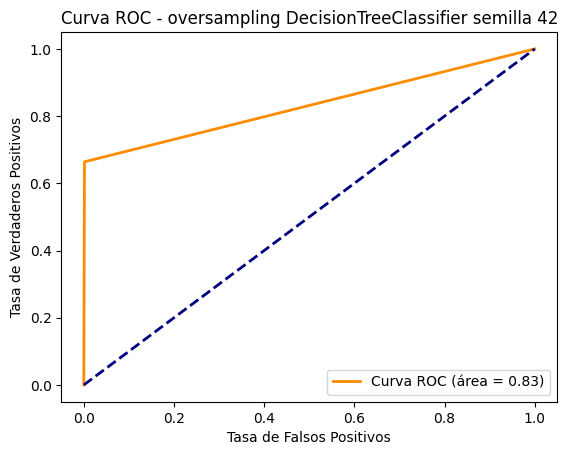

--> Final de oversampling para DecisionTreeClassifier con semilla 42
  DecisionTreeClassifier - oversampling (Semilla 42)
    Accuracy: 0.9966128778507507
    Precision: 0.7290209790209791
    Recall: 0.6640127388535032
    F1 Score: 0.695
    ROC-AUC: 0.8312849582534113
    Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Modelo guardado como model_DecisionTreeClassifier_oversampling_seed_42.pkl
--> Iniciando unbalanced para DecisionTreeClassifier

--> Iniciando unbalanced para DecisionTreeClassifier con semilla 42


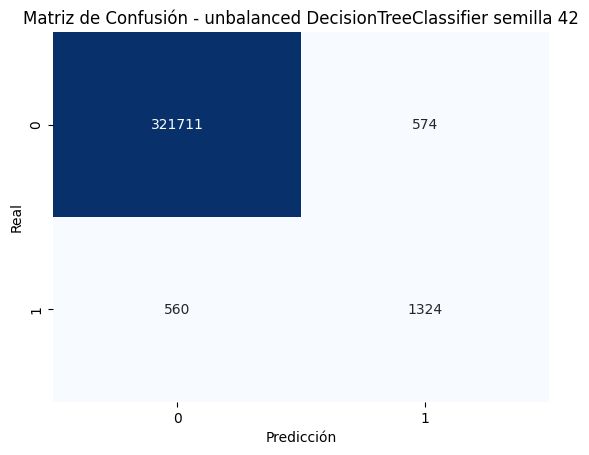

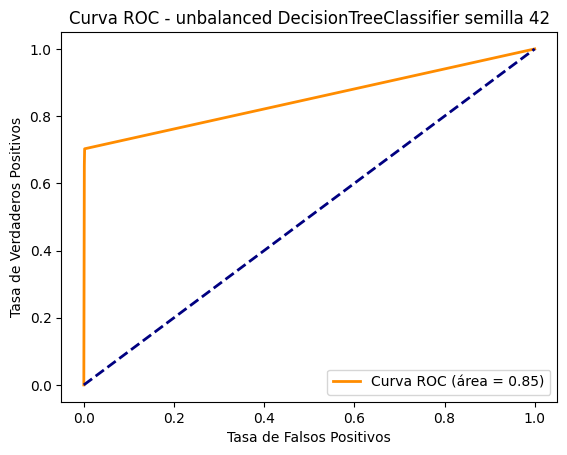

--> Final de unbalanced para DecisionTreeClassifier con semilla 42
  DecisionTreeClassifier - unbalanced (Semilla 42)
    Accuracy: 0.9965018246655294
    Precision: 0.6975763962065332
    Recall: 0.70276008492569
    F1 Score: 0.7001586462189318
    ROC-AUC: 0.8506751666139809
    Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Modelo guardado como model_DecisionTreeClassifier_unbalanced_seed_42.pkl
Modelo no encontrado: model_RandomForestClassifier_weighted_seed_42.pkl. Procediendo con el entrenamiento.
--> Iniciando weighted para RandomForestClassifier

--> Iniciando weighted para RandomForestClassifier con semilla 42


In [ ]:
models_and_params = [
    (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    #(LGBMClassifier(), {'num_leaves': [31, 50, 100], 'max_depth': [-1, 10, 20], 'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200]}),
    #(XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]}),
    #(CatBoostClassifier(silent=True), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1], 'iterations': [100, 200]})
]

seed_list = [42]#,15,1235,10101101]  # Puedes agregar más semillas aquí

for random_seed in seed_list:
    print(f"\n=== Evaluación con Semilla {random_seed} ===")

    # División de datos
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=random_seed
    )

    # Aplicar el preprocesador
    X_train_transformed = preprocessor.fit_transform(features_train)
    X_test_transformed = preprocessor.transform(features_test)

    # Lista de modelos y sus parámetros
    models_and_params = [
        #(LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
        (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
        (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
    ]

    for model_class, param_grid in models_and_params:
        model_name = model_class.__class__.__name__
        model_found = False  

        model_filename = f"model_{model_name}_weighted_seed_{random_seed}.pkl"
        if os.path.exists(model_filename):
            print(f"Modelo encontrado: {model_filename}")
            with open(model_filename, "rb") as file:
                model = pickle.load(file)

            # Realizar predicciones y mostrar métricas
            y_pred = model.predict(X_test_transformed)
            y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

            accuracy = accuracy_score(target_test, y_pred)
            precision = precision_score(target_test, y_pred)
            recall = recall_score(target_test, y_pred)
            f1 = f1_score(target_test, y_pred)
            roc_auc = roc_auc_score(target_test, y_pred)

            print_results((accuracy, precision, recall, f1, roc_auc, None, model), model_name, 'weighted', random_seed)

            # Matriz de Confusión
            cm = confusion_matrix(target_test, y_pred)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.title(f'Matriz de Confusión - {model_name} semilla {random_seed}')
            plt.xlabel("Predicción")
            plt.ylabel("Real")
            plt.show()

            # Curva ROC
            fpr, tpr, _ = roc_curve(target_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = {:.2f})'.format(roc_auc))
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('Tasa de Falsos Positivos')
            plt.ylabel('Tasa de Verdaderos Positivos')
            plt.title(f'Curva ROC - {model_name} semilla {random_seed}')
            plt.legend(loc="lower right")
            plt.show()

            model_found = True  

        if not model_found:
            print(f"Modelo no encontrado: {model_filename}. Procediendo con el entrenamiento.")

            # Con ajuste de peso de clase
            print(f"--> Iniciando weighted para {model_name}")
            results_weighted = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=1, random_seed=random_seed, balance_type='weighted'
            )
            print_results(results_weighted, model_name, 'weighted', random_seed)

            # Con submuestreo
            print(f"--> Iniciando undersampling para {model_name}")
            results_undersampling = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=2, random_seed=random_seed, balance_type='undersampling'
            )
            print_results(results_undersampling, model_name, 'undersampling', random_seed)

            # Con sobremuestreo
            print(f"--> Iniciando oversampling para {model_name}")
            results_oversampling = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=3, random_seed=random_seed, balance_type='oversampling'
            )
            print_results(results_oversampling, model_name, 'oversampling', random_seed)

            # Sin corrección de desequilibrio
            print(f"--> Iniciando unbalanced para {model_name}")
            results_unbalanced = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=None, random_seed=random_seed, balance_type='unbalanced'
            )
            print_results(results_unbalanced, model_name, 'unbalanced', random_seed)

# Almacenar los modelos y resultados
models_by_seed[random_seed] = models_by_model
results_by_seed[random_seed] = results_by_model


=== Evaluación con Semilla 42 ===
Modelo no encontrado: model_LogisticRegression_weighted_seed_42.pkl. Procediendo con el entrenamiento.
--> Iniciando weighted para LogisticRegression

--> Iniciando weighted para LogisticRegression con semilla 42


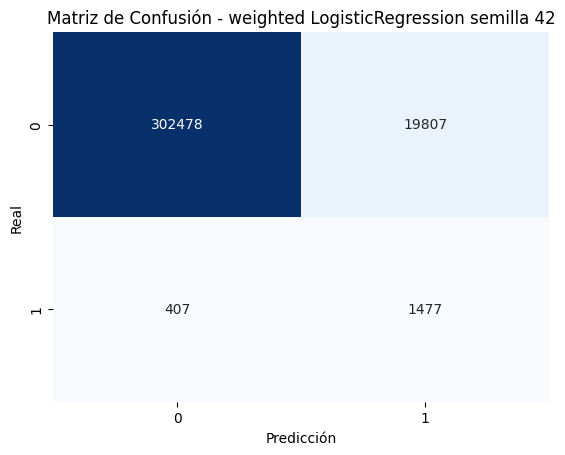

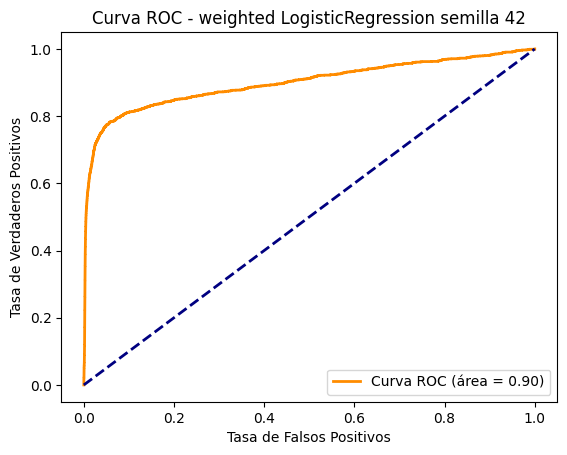

--> Final de weighted para LogisticRegression con semilla 42
  LogisticRegression - weighted (Semilla 42)
    Accuracy: 0.9376436364982463
    Precision: 0.06939485059199399
    Recall: 0.7839702760084926
    F1 Score: 0.12750345303867403
    ROC-AUC: 0.8988911665035698
    Best Parameters: {'C': 0.001}
Modelo guardado como model_LogisticRegression_weighted_seed_42.pkl
--> Iniciando undersampling para LogisticRegression

--> Iniciando undersampling para LogisticRegression con semilla 42


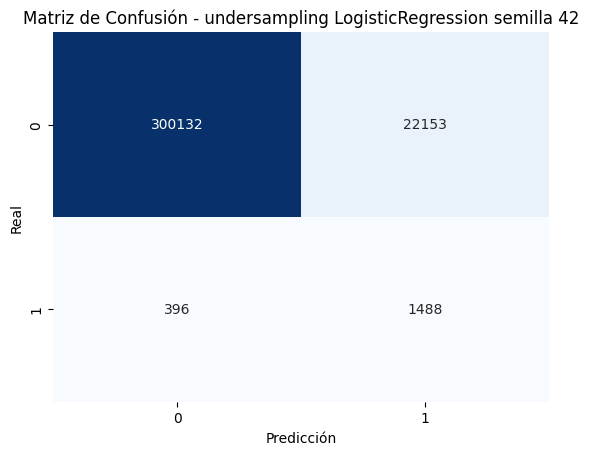

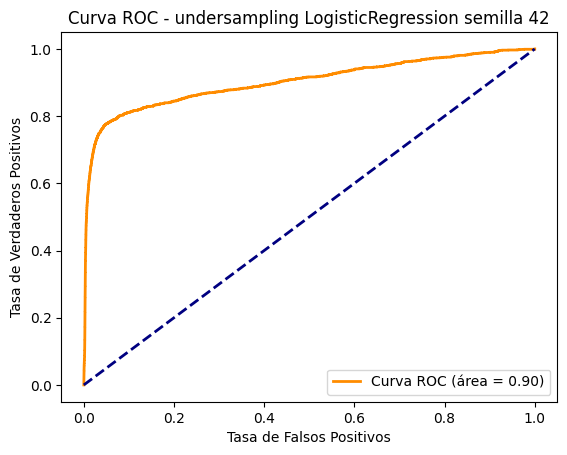

--> Final de undersampling para LogisticRegression con semilla 42
  LogisticRegression - undersampling (Semilla 42)
    Accuracy: 0.9304406035123655
    Precision: 0.0629414999365509
    Recall: 0.7898089171974523
    F1 Score: 0.11659157688540646
    ROC-AUC: 0.9020067971382821
    Best Parameters: {'C': 100}
Modelo guardado como model_LogisticRegression_undersampling_seed_42.pkl
--> Iniciando oversampling para LogisticRegression

--> Iniciando oversampling para LogisticRegression con semilla 42


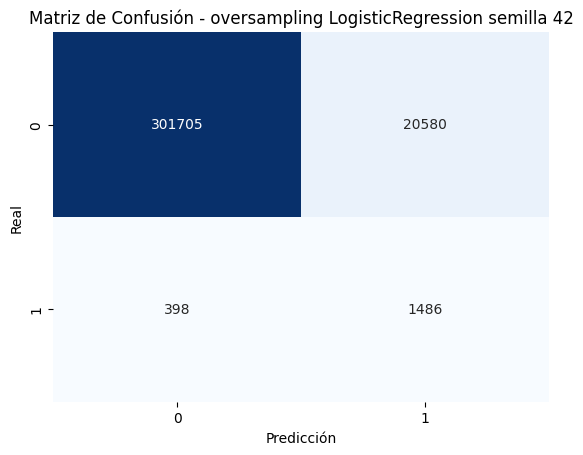

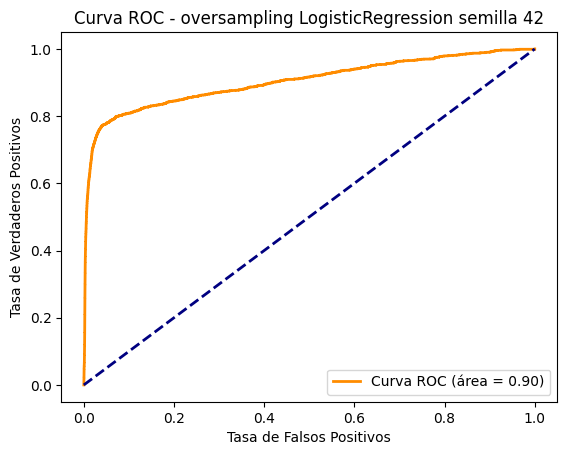

--> Final de oversampling para LogisticRegression con semilla 42
  LogisticRegression - oversampling (Semilla 42)
    Accuracy: 0.9352868411229945
    Precision: 0.06734342427263663
    Recall: 0.7887473460721869
    F1 Score: 0.12409185803757829
    ROC-AUC: 0.9034707975464609
    Best Parameters: {'C': 1}
Modelo guardado como model_LogisticRegression_oversampling_seed_42.pkl
--> Iniciando unbalanced para LogisticRegression

--> Iniciando unbalanced para LogisticRegression con semilla 42


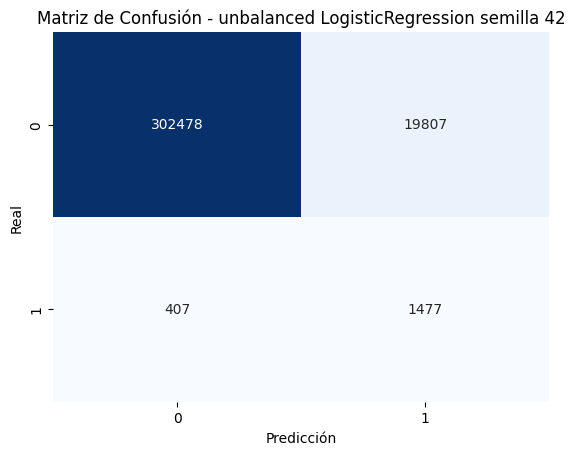

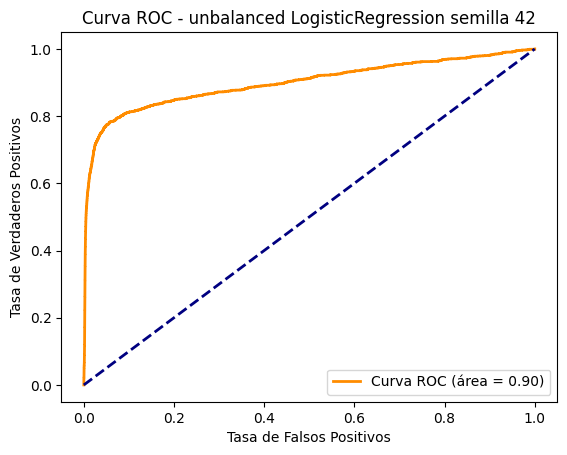

--> Final de unbalanced para LogisticRegression con semilla 42
  LogisticRegression - unbalanced (Semilla 42)
    Accuracy: 0.9376436364982463
    Precision: 0.06939485059199399
    Recall: 0.7839702760084926
    F1 Score: 0.12750345303867403
    ROC-AUC: 0.8988911665035698
    Best Parameters: {'C': 0.001}
Modelo guardado como model_LogisticRegression_unbalanced_seed_42.pkl
Modelo no encontrado: model_DecisionTreeClassifier_weighted_seed_42.pkl. Procediendo con el entrenamiento.
--> Iniciando weighted para DecisionTreeClassifier

--> Iniciando weighted para DecisionTreeClassifier con semilla 42


In [ ]:
models_and_params = [
    (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    #(LGBMClassifier(), {'num_leaves': [31, 50, 100], 'max_depth': [-1, 10, 20], 'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [100, 200]}),
    #(XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]}),
    #(CatBoostClassifier(silent=True), {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1], 'iterations': [100, 200]})
]

seed_list = [42]#,15,1235,10101101]  # Puedes agregar más semillas aquí

for random_seed in seed_list:
    print(f"\n=== Evaluación con Semilla {random_seed} ===")

    # División de datos
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=random_seed
    )

    # Aplicar el preprocesador
    X_train_transformed = preprocessor.fit_transform(features_train)
    X_test_transformed = preprocessor.transform(features_test)

    # Lista de modelos y sus parámetros
    models_and_params = [
        (LogisticRegression(max_iter=1000), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
        (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
        (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
    ]

    for model_class, param_grid in models_and_params:
        model_name = model_class.__class__.__name__
        model_found = False  

        model_filename = f"model_{model_name}_weighted_seed_{random_seed}.pkl"
        if os.path.exists(model_filename):
            print(f"Modelo encontrado: {model_filename}")
            with open(model_filename, "rb") as file:
                model = pickle.load(file)

            # Realizar predicciones y mostrar métricas
            y_pred = model.predict(X_test_transformed)
            y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

            accuracy = accuracy_score(target_test, y_pred)
            precision = precision_score(target_test, y_pred)
            recall = recall_score(target_test, y_pred)
            f1 = f1_score(target_test, y_pred)
            roc_auc = roc_auc_score(target_test, y_pred)

            print_results((accuracy, precision, recall, f1, roc_auc, None, model), model_name, 'weighted', random_seed)

            # Matriz de Confusión
            cm = confusion_matrix(target_test, y_pred)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.title(f'Matriz de Confusión - {model_name} semilla {random_seed}')
            plt.xlabel("Predicción")
            plt.ylabel("Real")
            plt.show()

            # Curva ROC
            fpr, tpr, _ = roc_curve(target_test, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = {:.2f})'.format(roc_auc))
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('Tasa de Falsos Positivos')
            plt.ylabel('Tasa de Verdaderos Positivos')
            plt.title(f'Curva ROC - {model_name} semilla {random_seed}')
            plt.legend(loc="lower right")
            plt.show()

            model_found = True  

        if not model_found:
            print(f"Modelo no encontrado: {model_filename}. Procediendo con el entrenamiento.")

            # Con ajuste de peso de clase
            print(f"--> Iniciando weighted para {model_name}")
            results_weighted = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=1, random_seed=random_seed, balance_type='weighted'
            )
            print_results(results_weighted, model_name, 'weighted', random_seed)

            # Con submuestreo
            print(f"--> Iniciando undersampling para {model_name}")
            results_undersampling = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=2, random_seed=random_seed, balance_type='undersampling'
            )
            print_results(results_undersampling, model_name, 'undersampling', random_seed)

            # Con sobremuestreo
            print(f"--> Iniciando oversampling para {model_name}")
            results_oversampling = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=3, random_seed=random_seed, balance_type='oversampling'
            )
            print_results(results_oversampling, model_name, 'oversampling', random_seed)

            # Sin corrección de desequilibrio
            print(f"--> Iniciando unbalanced para {model_name}")
            results_unbalanced = grid_search_with_and_without_balance(
                model_class, param_grid, X_train_transformed, target_train,
                X_test_transformed, target_test, sampler=None, random_seed=random_seed, balance_type='unbalanced'
            )
            print_results(results_unbalanced, model_name, 'unbalanced', random_seed)

# Almacenar los modelos y resultados
models_by_seed[random_seed] = models_by_model
results_by_seed[random_seed] = results_by_model